In [8]:
!pip install torch
!pip install torchdiffeq


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\flysh\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\flysh\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [1]:
# 1 Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchdiffeq import odeint

## Synthetic part
import numpy as np
from scipy.integrate import solve_ivp

In [2]:
#2 Physical Model Params

# Constants
g = 9.81
L1, L2 = 1.0, 1.0  # lengths of the pendulums
m1, m2 = 1.0, 1.0  # masses

In [3]:
# 3.1 Generating Y actual - for training and testing data

# Differential equations for the double pendulum
def double_pendulum(t, y):
    theta1, omega1, theta2, omega2 = y
    delta = theta2 - theta1

    den1 = (2 * m1 + m2 - m2 * np.cos(2 * delta))
    den2 = den1

    dtheta1_dt = omega1

    domega1_dt = (
        -g * (2 * m1 + m2) * np.sin(theta1)
        - m2 * g * np.sin(theta1 - 2 * theta2)
        - 2 * np.sin(delta) * m2 * (omega2**2 * L2 + omega1**2 * L1 * np.cos(delta))
    ) / (L1 * den1)

    dtheta2_dt = omega2

    domega2_dt = (
        2 * np.sin(delta) * (
            omega1**2 * L1 * (m1 + m2)
            + g * (m1 + m2) * np.cos(theta1)
            + omega2**2 * L2 * m2 * np.cos(delta)
        )
    ) / (L2 * den2)

    return [dtheta1_dt, domega1_dt, dtheta2_dt, domega2_dt]

# Initial conditions: [theta1, omega1, theta2, omega2]
y0_np = [np.pi / 2, 0, np.pi / 2, 0]

# Time grid
t_span = (0, 5)
t_eval = np.linspace(*t_span, 1000)

# Solve the ODE
sol = solve_ivp(double_pendulum, t_span, y0_np, t_eval=t_eval)

# Extract angles
theta1 = sol.y[0]
theta2 = sol.y[2]

Y_true  = sol.y.T.astype(np.float32)   # shape (T, 4)

In [86]:
# import os
# import numpy as np
# #3.2 Using the physical pendulum dataset
# # Use the real double pendulum dataset: reconstruct [θ1, ω1, θ2, ω2]
# trials = ['Trial1', 'Trial2', 'Trial3']

# all_t = []
# all_states = []   # each element will be (T, 4) = [θ1, ω1, θ2, ω2]

# for trial in trials:
#     # Load angle means
#     DPmean_data_RB0 = np.load(os.path.join(trial, 'DPmean_data_RB0.npy'))
#     DPmean_data_RB1 = np.load(os.path.join(trial, 'DPmean_data_RB1.npy'))

#     # Assume shape (2, N): [0]=time, [1]=angle (radians)
#     t_trial = DPmean_data_RB0[0]   # (N,)
#     phi1    = DPmean_data_RB0[1]   # (N,)
#     phi2    = DPmean_data_RB1[1]   # (N,)

#     # Angular velocities via finite differences: dφ/dt (rad/s)
#     omega1 = np.gradient(phi1, t_trial)
#     omega2 = np.gradient(phi2, t_trial)

#     # Stack into (N, 4) : [θ1, ω1, θ2, ω2]
#     states_trial = np.stack([phi1, omega1, phi2, omega2], axis=-1)  # (N, 4)

#     all_t.append(t_trial)
#     all_states.append(states_trial.astype(np.float32))

#     print(f"{trial}: t shape = {t_trial.shape}, states shape = {states_trial.shape}")

# # For now, just train on Trial1
# t_eval = all_t[0]          # (T,)
# Y_true = all_states[0]     # (T, 4), dtype float32



# print("Using REAL pendulum data from", trials[0])
# print("t_eval shape:", t_eval.shape)
# print("Y_true shape:", Y_true.shape)

# DS = 40  # down sampling bc dataset is 38k points
# t_eval = t_eval[::DS]
# Y_true = Y_true[::DS]

# print("After downsampling:")
# print("t_eval shape:", t_eval.shape)
# print("Y_true shape:", Y_true.shape)

In [4]:
#4 Torch Tensors setting up the ODE
torch.manual_seed(67)  # Manual seed for randomization

# time vector (T,)
t = torch.tensor(t_eval, dtype=torch.float32)

# initial state y0 = [θ1(0), ω1(0), θ2(0), ω2(0)]
y0_torch = torch.tensor(Y_true[0], dtype=torch.float32)  # shape (4,)

# target trajectory (T, 4)
Y_true_t = torch.tensor(Y_true, dtype=torch.float32)

# Normalize the trajectory and initial condition
Y_mean = Y_true_t.mean(dim=0)
Y_std = Y_true_t.std(dim=0)

Y_true_norm = (Y_true_t - Y_mean) / Y_std
y0_norm = (y0_torch - Y_mean) / Y_std

Y_true_t = Y_true_norm
y0_torch = y0_norm


# ODE function f in dy/dt = f(t,y)
class ODEFunc(nn.Module):
  def __init__(self, in_dim = 4, out_dim=4, hidden = (10, 10, 10, 10),act=nn.Tanh):
    # num_in_out = 4 for the 2 angles and 2 angular velocities (or whichever parameters you want)
    super().__init__()
    dims = [in_dim, *hidden, out_dim]

    # The following is an MLP with x hidden layers
    layers = []
    for i in range(len(dims) - 1):
      layers.append(nn.Linear(dims[i], dims[i+1]))
      if i < len(dims) - 2:           # no activation after last Linear
        layers.append(act())
    self.net = nn.Sequential(*layers)

  def forward(self, t, y):
    # takes (4,) or (B,4) and returns same shape

    # y is a torch vector representing the current state
    # t is there just to match the expected function signature
    # need to make sure that the shapes are of form (B, 4)
    squeezed = False
    if y.dim() == 1:
      y = y.unsqueeze(0)  # (1,4)
      squeezed = True
    dy = self.net(y)         # (B,4)
    return dy.squeeze(0) if squeezed else dy # if y is (4,), Linear wants (B,4)

In [5]:
#5 Neural ODE model

class NeuralODE(nn.Module):
    def __init__(self, odefunc, method='', rtol=1e-6, atol=1e-6):
        super().__init__()
        self.odefunc = odefunc
        self.method = method
        self.rtol = rtol
        self.atol = atol
        self._odeint = odeint

    def forward(self, y0, t):
        return self._odeint(self.odefunc, y0, t,
                            method=self.method, rtol=self.rtol, atol=self.atol)


# import torch
# from torchdiffeq import odeint

# _FIXED_STEP = {"euler", "midpoint", "rk4", "explicit_adams", "implicit_adams"}

# class NeuralODE(torch.nn.Module):
#     def __init__(self, f, method="rk4", step_size=None, rtol=1e-5, atol=1e-7):
#         super().__init__()
#         self.f = f
#         self.method = method
#         self.step_size = step_size
#         self.rtol = rtol
#         self.atol = atol

#     def forward(self, y0, t):
#         kwargs = {"method": self.method}

#         if self.method in _FIXED_STEP:
#             # fixed-step solvers require a step size
#             step = float(t[1] - t[0]) if self.step_size is None else float(self.step_size)
#             kwargs["options"] = {"step_size": step}
#         else:
#             # adaptive solvers use tolerances
#             kwargs["rtol"] = self.rtol
#             kwargs["atol"] = self.atol

#         # returns shape (T, state_dim)
#         return odeint(self.f, y0, t, **kwargs)


In [8]:
#6 Training setup

f = ODEFunc(in_dim = 4, out_dim=4, hidden=(128,128))
opt = torch.optim.Adam(f.parameters(), lr=1e-3)
neural_ode = NeuralODE(f, method='dopri5', rtol=1e-4, atol=1e-4)
max_epochs = 200

t_train      = t
Y_true_train = Y_true_t

In [ ]:
#7 Training loop

window_size = 100        # number of steps per window
num_windows_per_epoch = 20   # how many windows sampled each epoch

f.train()
for epoch in range(max_epochs):

    epoch_loss = 0.0

    for k in range(num_windows_per_epoch):

        # 1. Randomly pick a window start index
        i = torch.randint(0, len(t_train) - window_size, (1,)).item()

        # 2. Extract window time values and target states
        t_window = t_train[i : i + window_size]
        Y_window_true = Y_true_train[i : i + window_size]   # shape [window, 4]

        # 3. Initial condition for this window
        y0_window = Y_window_true[0]

        # 4. Predict using Neural ODE
        Y_window_pred = neural_ode(y0_window, t_window)

        # 5. Compute loss on the window
        loss = F.mse_loss(Y_window_pred, Y_window_true)
        epoch_loss += loss.item()

        # 6. Gradient step
        opt.zero_grad()
        loss.backward()
        opt.step()

    if epoch % 10 == 0:
        print(f"epoch {epoch}: windowed_loss = {epoch_loss/num_windows_per_epoch:.6f}")

# Save the trained model weights
torch.save(f.state_dict(), "Neural_ODE_weights.pth")


epoch 0: windowed_loss = 0.663986
epoch 10: windowed_loss = 0.181098
epoch 20: windowed_loss = 0.219357
epoch 30: windowed_loss = 0.161637
epoch 40: windowed_loss = 0.129858
epoch 50: windowed_loss = 0.138199
epoch 60: windowed_loss = 0.072869
epoch 70: windowed_loss = 0.094415
epoch 80: windowed_loss = 0.119259
epoch 90: windowed_loss = 0.097762
epoch 100: windowed_loss = 0.061383
epoch 110: windowed_loss = 0.045804
epoch 120: windowed_loss = 0.050386
epoch 130: windowed_loss = 0.050978
epoch 140: windowed_loss = 0.045865
epoch 150: windowed_loss = 0.050497
epoch 160: windowed_loss = 0.042300
epoch 170: windowed_loss = 0.035704
epoch 180: windowed_loss = 0.023316
epoch 190: windowed_loss = 0.066326


In [ ]:
#8 Training the Neural ODE

# import torch
# import torch.nn as nn
# import numpy as np
# import matplotlib.pyplot as plt

# def rmse(pred, target):
#     return torch.sqrt(torch.mean((pred - target) ** 2)).item()

# # Pick solvers to compare
# methods_to_try = [
#     ("euler",    dict(method="euler")),
#     ("midpoint", dict(method="midpoint")),
#     ("rk4",      dict(method="rk4")),
#     ("dopri5",   dict(method="dopri5", rtol=1e-5, atol=1e-7)),
#     ("bosh3",    dict(method="bosh3",  rtol=1e-5, atol=1e-7)),
# ]

# num_epochs = 200
# lr = 1e-3

# results = {}

# for name, solver_kwargs in methods_to_try:
#     torch.manual_seed(67)

#     # IMPORTANT: create a fresh dynamics net and NeuralODE each time
#     func = ODEFunc()                 # <-- use YOUR class name from #5 (ODEFunc / ODEFuncNN etc.)
#     model = NeuralODE(func, **solver_kwargs)

#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#     criterion = nn.MSELoss()

#     loss_hist = []

#     for epoch in range(num_epochs):
#         optimizer.zero_grad()

#         Y_hat = model(y0_torch, t)        # (T,4)
#         loss = criterion(Y_hat, Y_true_t) # compare to data

#         loss.backward()
#         optimizer.step()

#         loss_hist.append(loss.item())

#     with torch.no_grad():
#         Y_hat = model(y0_torch, t)
#         final_rmse = rmse(Y_hat, Y_true_t)

#     results[name] = {
#         "loss_hist": loss_hist,
#         "final_loss": loss_hist[-1],
#         "final_rmse": final_rmse,
#     }

#     print(f"{name:8s}  final_loss={loss_hist[-1]:.4e}  final_RMSE={final_rmse:.4e}")

# # Plot loss curves
# plt.figure()
# for name in results:
#     plt.plot(results[name]["loss_hist"], label=name)
# plt.yscale("log")
# plt.xlabel("Epoch")
# plt.ylabel("Train MSE Loss")
# plt.legend()
# plt.show()


euler     final_loss=2.2097e+01  final_RMSE=4.7007e+00


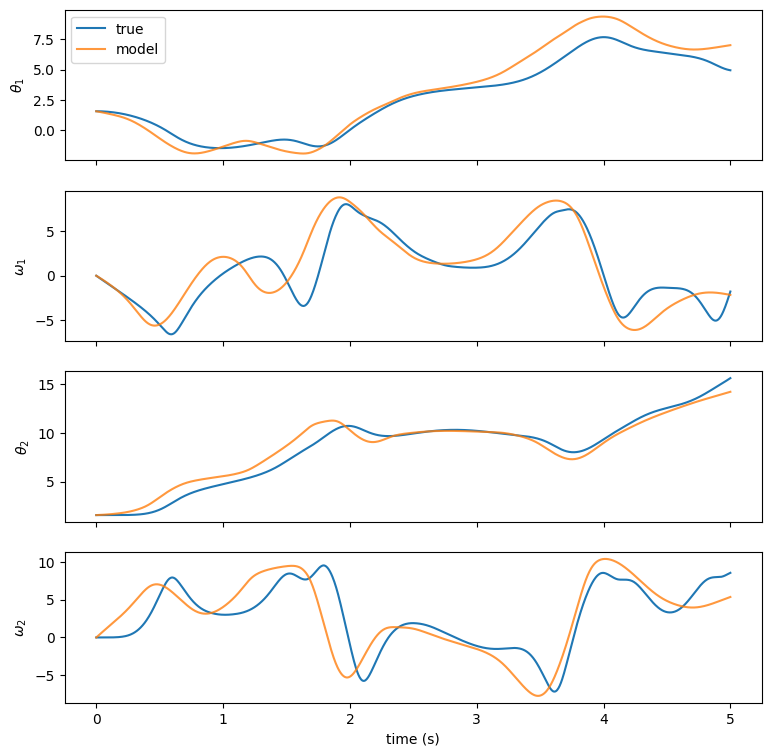

RMSE [θ1, ω1, θ2, ω2] = [1.0092218  2.228653   0.81815845 2.916585  ]


In [ ]:
# plot
import matplotlib.pyplot as plt
import numpy as np

# Load the trained model weights
f.load_state_dict(torch.load("Neural_ODE_weights.pth"))

f.eval()
with torch.no_grad():
    Y_hat_full = odeint(f, y0_torch, t, method='dopri5').numpy()

# denormalize model prediction
Y_hat_full = Y_hat_full * Y_std.numpy() + Y_mean.numpy()

fig, axs = plt.subplots(4, 1, figsize=(9, 9), sharex=True)
names = [r"$\theta_1$", r"$\omega_1$", r"$\theta_2$", r"$\omega_2$"]

for i, ax in enumerate(axs):
    ax.plot(t_eval, Y_true[:, i], label="true", linewidth=1.5)
    ax.plot(t_eval, Y_hat_full[:, i], label="model", alpha=0.8)
    ax.set_ylabel(names[i])

axs[-1].set_xlabel("time (s)")
axs[0].legend()
plt.show()

# root mean squared error per state
rmse = np.sqrt(((Y_hat_full - Y_true)**2).mean(axis=0))
print("RMSE [θ1, ω1, θ2, ω2] =", rmse)

In [ ]:
# Training Setup

# Load Dataset (probably using Pandas)

# Make a train-test split

# Train the model with x epochs